# Analysing H1B Acceptance Trends 

H1B visa is a nonimmigrant visa issued to gradute level workers which allows them to work in the United States. The employer sponsors the H1B visa for workers with theoretical or technical expertise in specialized fields such as in IT, finance, accounting etc. An interesting fact about immigrant workers is that about 52 percent of new Silicon valley companies were founded by such workers during 1995 and 2005. Some famous CEOs like Indira Nooyi (Pepsico), Elon Musk (Tesla), Sundar Pichai (Google),Satya Nadella (Microsoft) once arrived to the US on a H1B visa.

**Motivation**: Our team consists of five international gradute students, in the future we will be applying for H1B visa. The visa application process seems very long, complicated and uncertain. So we decided to understand this process and use Machine learning algorithms to predict the acceptance rate and trends of H1B visa. 

## Data 
The data used in the project has been collected from <a href="https://www.foreignlaborcert.doleta.gov/performancedata.cfm">the Office of Foreign Labor Certification (OFLC).</a> 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install autocorrect
import pandas as pd
import numpy as np
import warnings
import nltk
from textblob import TextBlob
from autocorrect import Speller 
nltk.download('wordnet')

     |████████████████████████████████| 1.8MB 3.4MB/s 
  Created wheel for autocorrect: filename=autocorrect-1.1.0-cp36-none-any.whl size=1810772 sha256=f841950148a2cc15090f6756cdd2e49171d255b72c405b5cbab40ab51be46045
  Stored in directory: /root/.cache/pip/wheels/78/7f/b1/527522820ae623df6a2dbe14f778d23adaea4bebe43f7ebcfe
Successfully built autocorrect
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Exploratory Data Analysis

Before we begin working on our data we need to understand the traits of our data which we accomplish using EDA. We see that we have about 260 columns , not all 260 columns have essential information that contributes to our analysis. Hence we pick out the columns such as case status( Accepted/ Denied) ,Employer, Job title etc. 

In [0]:
#Read the csv file and stored in file
file=pd.read_csv('/content/gdrive/My Drive/H-1B_Disclosure_Data_FY2019.csv')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,13,14,19,20,21,22,23,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,57,58,59,61,64,66,67,68,69,70,71,72,73,76,78,79,80,82,85,87,88,89,90,91,92,93,94,97,98,99,100,101,103,106,108,109,110,111,112,113,114,115,121,122,124,127,129,130,131,132,133,134,135,136,142,143,145,148,150,151,152,153,154,155,156,157,160,162,163,164,166,169,171,172,173,174,175,176,177,178,184,185,187,190,192,193,194,195,196,197,198,199,205,206,208,211,213,214,215,216,217,218,219,220,223,225,226,227,229,232,234,235,236,237,238,239,240,244,246,247,248,250,253,254,255,256,257,258,259) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
file.shape

(1048548, 260)

In [0]:
cleaned=file[['CASE_NUMBER','CASE_STATUS','CASE_SUBMITTED','DECISION_DATE','VISA_CLASS','FULL_TIME_POSITION','JOB_TITLE','SOC_CODE','SOC_TITLE',\
              'EMPLOYER_NAME','WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1','NAICS_CODE','WORKSITE_CITY_1','WORKSITE_STATE_1']]
cleaned.head()

,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,FULL_TIME_POSITION,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,WAGE_RATE_OF_PAY_FROM_1,WAGE_UNIT_OF_PAY_1,NAICS_CODE,WORKSITE_CITY_1,WORKSITE_STATE_1
0,I-200-16092-327771,WITHDRAWN,4/8/2016,4/30/2019,H-1B,Y,ASSOCIATE CREATIVE DIRECTOR,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"R/GA MEDIA GROUP, INC.","$179,000.00",Year,541810.0,NEW YORK,NY
1,I-203-17188-450729,WITHDRAWN,7/14/2017,5/13/2019,E-3 Australian,Y,ACCOUNT SUPERVISOR (MOTHER),11-2011,ADVERTISING AND PROMOTIONS MANAGERS,MOTHER INDUSTRIES LLC,"$110,000.00",Year,541810.0,NEW YORK,NY
2,I-203-17229-572307,WITHDRAWN,8/23/2017,4/30/2019,E-3 Australian,Y,EXECUTIVE CREATIVE DIRECTOR,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"WE ARE UNLIMITED, INC.","$275,000.00",Year,541810.0,CHICAGO,IL
3,I-203-17356-299648,WITHDRAWN,12/22/2017,8/20/2019,E-3 Australian,Y,PROJECT MANAGEMENT LEAD,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"HELLO ELEPHANT, LLC","$140,000.00",Year,541810.0,BROOKLYN,NY
4,I-203-18008-577576,WITHDRAWN,1/10/2018,4/15/2019,E-3 Australian,Y,"CREATIVE DIRECTOR, UX",11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"HELLO ELEPHANT, LLC","$180,000.00",Year,541810.0,BROOKLYN,NY


In [0]:
cleaned.shape

(1048548, 15)

In [0]:
cleaned['VISA_CLASS'].value_counts()

H-1B               649083
E-3 Australian      13087
H-1B1 Singapore      1291
H-1B1 Chile          1155
Name: VISA_CLASS, dtype: int64

In [0]:
# Visa class has many categories which are not of use , we require only H1B visa type , hence we drop all records with other visa types
cleaned.drop(labels=cleaned.loc[cleaned['VISA_CLASS']!='H-1B'].index , inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
cleaned['FULL_TIME_POSITION'].value_counts()

Y    638346
N     10737
Name: FULL_TIME_POSITION, dtype: int64

In [0]:
cleaned['CASE_STATUS'].value_counts()

CERTIFIED              578640
CERTIFIED-WITHDRAWN     46050
WITHDRAWN               19227
DENIED                   5166
Name: CASE_STATUS, dtype: int64

In [0]:
#As we want to only need accepted and denied cases we are dropping withdrawn from the data frame. 
#Case status of class certified-withdraw were certified earlier and later withdraw which can be considered a
cleaned.replace({"CASE_STATUS":"CERTIFIED-WITHDRAWN"},"CERTIFIED",inplace=True)
cleaned.drop(labels=cleaned.loc[cleaned['CASE_STATUS']=='WITHDRAWN'].index , inplace=True)
cleaned.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,FULL_TIME_POSITION,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,WAGE_RATE_OF_PAY_FROM_1,WAGE_UNIT_OF_PAY_1,NAICS_CODE,WORKSITE_CITY_1,WORKSITE_STATE_1
18,I-200-17250-072640,CERTIFIED,9/7/2017,1/7/2019,H-1B,Y,"EXECUTIVE DIRECTOR, STRATEGY",11-2011,ADVERTISING AND PROMOTIONS MANAGERS,FIGLIULO & PARTNERS LLC,"$230,000.00",Year,541810.0,NEW YORK,NY
19,I-200-18026-717110,CERTIFIED,1/26/2018,7/5/2019,H-1B,Y,PROJECT OPERATIONS MANAGER,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,INVISIONAPP INC.,"$107,000.00",Year,541511.0,SAN FRANCISCO,CA
21,I-200-18039-081565,CERTIFIED,3/5/2018,1/8/2019,H-1B,Y,MANAGER OF LEAGUE AND TOURNAMENT SERVICES,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,OREGON YOUTH SOCCER ASSOCIATION,"$49,087.00",Year,61162.0,BEAVERTON,OR
22,I-200-18082-340860,CERTIFIED,3/23/2018,4/22/2019,H-1B,Y,"DIRECTOR, DEMAND",11-2011,ADVERTISING AND PROMOTIONS MANAGERS,"FACTUAL, INC.","$172,930.00",Year,511210.0,NEW YORK,NY
24,I-200-18162-689783,CERTIFIED,9/26/2018,10/2/2018,H-1B,N,ADVERSTING AND PROMOTIONS MANAGER,11-2011,ADVERTISING AND PROMOTIONS MANAGERS,FANTUAN GROUP INC,$33.00,Hour,511210.0,CHICAGO,IL


In [0]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629856 entries, 18 to 664616
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CASE_NUMBER              629855 non-null  object 
 1   CASE_STATUS              629856 non-null  object 
 2   CASE_SUBMITTED           629856 non-null  object 
 3   DECISION_DATE            629856 non-null  object 
 4   VISA_CLASS               629856 non-null  object 
 5   FULL_TIME_POSITION       629856 non-null  object 
 6   JOB_TITLE                629856 non-null  object 
 7   SOC_CODE                 629852 non-null  object 
 8   SOC_TITLE                629852 non-null  object 
 9   EMPLOYER_NAME            629848 non-null  object 
 10  WAGE_RATE_OF_PAY_FROM_1  629852 non-null  object 
 11  WAGE_UNIT_OF_PAY_1       629852 non-null  object 
 12  NAICS_CODE               629855 non-null  float64
 13  WORKSITE_CITY_1          629785 non-null  object 
 14  WOR

In [0]:
#the column wages has a mix of both string and float value types and some record have the symbol '$' which we want to remove
cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(type).value_counts()

<class 'float'>    460442
<class 'str'>      169414
Name: WAGE_RATE_OF_PAY_FROM_1, dtype: int64

In [0]:
cleaned['WORKSITE_STATE_1'].apply(type).value_counts()

<class 'str'>      629845
<class 'float'>        11
Name: WORKSITE_STATE_1, dtype: int64

In [0]:
def clean_wages(w):
    """ Function to remove '$' symbol and other delimiters from wages column which consistes of str and float type values
    if the column entry is string type then remove the symbols else return the column value as it is 
    """
    if isinstance(w, str):
        return(w.replace('$', '').replace(',', ''))
    return(w)

In [0]:
cleaned['WAGES']=cleaned['WAGE_RATE_OF_PAY_FROM_1'].apply(clean_wages).astype('float')
cleaned.info()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 629856 entries, 18 to 664616
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CASE_NUMBER              629855 non-null  object 
 1   CASE_STATUS              629856 non-null  object 
 2   CASE_SUBMITTED           629856 non-null  object 
 3   DECISION_DATE            629856 non-null  object 
 4   VISA_CLASS               629856 non-null  object 
 5   FULL_TIME_POSITION       629856 non-null  object 
 6   JOB_TITLE                629856 non-null  object 
 7   SOC_CODE                 629852 non-null  object 
 8   SOC_TITLE                629852 non-null  object 
 9   EMPLOYER_NAME            629848 non-null  object 
 10  WAGE_RATE_OF_PAY_FROM_1  629852 non-null  object 
 11  WAGE_UNIT_OF_PAY_1       629852 non-null  object 
 12  NAICS_CODE               629855 non-null  float64
 13  WORKSITE_CITY_1          629785 non-null  object 
 14  WOR

In [0]:
# the wage information that we have available has different unit of pay
cleaned['WAGE_UNIT_OF_PAY_1'].value_counts()

Year         587386
Hour          41927
Month           342
Bi-Weekly       105
Week             92
Name: WAGE_UNIT_OF_PAY_1, dtype: int64

In [0]:
x=cleaned.loc[cleaned['WAGE_UNIT_OF_PAY_1']=="Month"]
x.head(2)


,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,DECISION_DATE,VISA_CLASS,FULL_TIME_POSITION,JOB_TITLE,SOC_CODE,SOC_TITLE,EMPLOYER_NAME,WAGE_RATE_OF_PAY_FROM_1,WAGE_UNIT_OF_PAY_1,NAICS_CODE,WORKSITE_CITY_1,WORKSITE_STATE_1,WAGES
818,I-200-18306-399497,DENIED,11/02/2018 11:37:37,11/05/2018 12:07:42,H-1B,Y,ACCOUNTING & MARKETING MANAGER FOR AFRICA,11-2021,MARKETING MANAGERS,SHOP2SHIP LLC,2000,Month,541614.0,DORAL,FL,2000.0
826,I-200-18309-843479,CERTIFIED,11/05/2018 12:34:19,11/09/2018 22:00:34,H-1B,Y,ACCOUNTING & MARKETING MANAGER FOR AFRICA,11-2021,MARKETING MANAGERS,SHOP2SHIP LLC,2000,Month,541614.0,DORAL,FL,2000.0


In [0]:
# we convert the different units of pay to the type 'Year'
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Month',cleaned['WAGES'] * 12,cleaned['WAGES'])
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Hour',cleaned['WAGES'] * 2080,cleaned['WAGES']) # 2080=8 hours*5 days* 52 weeks
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Bi-Weekly',cleaned['WAGES'] *26,cleaned['WAGES'])
cleaned['WAGES'] = np.where(cleaned['WAGE_UNIT_OF_PAY_1'] == 'Week',cleaned['WAGES'] * 52,cleaned['WAGES'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
#As we have got the information of Wages and made transformation we can drop the initial two records
cleaned.drop(columns=['WAGE_RATE_OF_PAY_FROM_1','WAGE_UNIT_OF_PAY_1'],axis=1,inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629856 entries, 18 to 664616
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CASE_NUMBER         629855 non-null  object 
 1   CASE_STATUS         629856 non-null  object 
 2   CASE_SUBMITTED      629856 non-null  object 
 3   DECISION_DATE       629856 non-null  object 
 4   VISA_CLASS          629856 non-null  object 
 5   FULL_TIME_POSITION  629856 non-null  object 
 6   JOB_TITLE           629856 non-null  object 
 7   SOC_CODE            629852 non-null  object 
 8   SOC_TITLE           629852 non-null  object 
 9   EMPLOYER_NAME       629848 non-null  object 
 10  NAICS_CODE          629855 non-null  float64
 11  WORKSITE_CITY_1     629785 non-null  object 
 12  WORKSITE_STATE_1    629845 non-null  object 
 13  WAGES               629852 non-null  float64
dtypes: float64(2), object(12)
memory usage: 72.1+ MB


In [0]:
"""
We should remove record that have null objects, from the above cell we see
that all columns don't have same number of non-null records
which means we have to remove the records that have the null values.
we see that there are about 17 records that have null values
""" 
null_rows = cleaned.isnull().any(axis=1)
print(cleaned[null_rows].shape)
print(cleaned.shape)

(92, 14)
(629856, 14)


In [0]:
cleaned.dropna(inplace=True)
print(cleaned.shape)

(629764, 14)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
cleaned['JOB_TITLE'].value_counts()

SOFTWARE ENGINEER                            33199
SOFTWARE DEVELOPER                           33054
SENIOR SYSTEMS ANALYST JC60                  12759
SENIOR SOFTWARE ENGINEER                      8132
MANAGER JC50                                  8118
                                             ...  
FULLFILLMENT PLANNING ANALYST                    1
SAP ABAP  CONSULTANT                             1
SENIOR ENGINEER, PERFORMANCE & MONITORING        1
PRODUCTION PLANNING ENGINEER                     1
PROFESSOR OF ACCOUNTING                          1
Name: JOB_TITLE, Length: 108127, dtype: int64

In [0]:
#we see that the job title has integers(words with integers also) 
#removing comma also
def remove_num(text):
  if not any(c.isdigit() for c in text):
    return text
  return ''
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([remove_num(i) for i in txt.lower().split()]))
cleaned['JOB_TITLE']=cleaned['JOB_TITLE'].str.replace(',', '')
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([remove_num(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned['SOC_TITLE'].str.replace(',', '')

cleaned.head()
cleaned['JOB_TITLE'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

software engineer                                     33391
software developer                                    33143
senior systems analyst                                12760
senior software engineer                               8146
manager                                                8127
                                                      ...  
clinical instructor-radiology locum                       1
senior system engineer- rail automation                   1
strategic operations senior manager                       1
sr. engineer  - peoplesoft developer                      1
senior user interface developer/software developer        1
Name: JOB_TITLE, Length: 96176, dtype: int64

In [0]:
#code to clean and group the JOB_TITLE COLUMN
# lemmatization and spell check function
nltk.download('words')
lemmatizer = nltk.stem.WordNetLemmatizer()
words = set(nltk.corpus.words.words())
spell = Speller()


def lemmatize_text(text):
  return lemmatizer.lemmatize(text)

def spelling_checker(text):
  return spell(text)
 
print(spelling_checker("computr sciece progam check"))

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
computer science program check


In [0]:
#this part takes more time because spell_checker 
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
print(' after lemmatization')
print(cleaned['JOB_TITLE'].value_counts() )
cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))
print('after spell correction')
#cleaned['JOB_TITLE']=cleaned.JOB_TITLE.apply(lambda txt: " ".join([remove_text(i) for i in txt.lower().split()]))
cleaned['JOB_TITLE'].value_counts() 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


 after lemmatization
software engineer                               40676
software developer                              33357
senior system analyst                           13300
manager                                          9598
senior software engineer                         8292
                                                ...  
president global healthcare practice                1
it process engineer ii                              1
network and server technical administrator          1
development product engineering professional        1
principal sourcing engineer                         1
Name: JOB_TITLE, Length: 92746, dtype: int64


KeyboardInterrupt: ignored

In [0]:
#clean SOC TITLE
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([lemmatize_text(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE']=cleaned.SOC_TITLE.apply(lambda txt: " ".join([spelling_checker(i) for i in txt.lower().split()]))
cleaned['SOC_TITLE'].value_counts() 

In [0]:
#we see that the job title has integers in the record which we can remove
cleaned['JOB_TITLE']=cleaned['JOB_TITLE'].str.replace('[0-9(){}[].]', '')
cleaned.head()

In [0]:
cleaned['SOC_TITLE'].value_counts()

SOFTWARE DEVELOPERS, APPLICATIONS                     208474
COMPUTER OCCUPATIONS, ALL OTHER                        54483
COMPUTER SYSTEMS ANALYST                               40568
COMPUTER SYSTEMS ANALYSTS                              30611
SOFTWARE DEVELOPERS, SYSTEMS SOFTWARE                  30576
                                                       ...  
HEALTH AND SAFETY ENGS., EXCEPT MINING SAFETY ENGS         1
DIAGNOSTIC MEDICAL SONOGRAPHERS                            1
PROOFREADERS AND COPY MARKERS                              1
DATA ENTRY KEYERS                                          1
CUMPUTER OCCUPATIONS, ALL OTHER                            1
Name: SOC_TITLE, Length: 851, dtype: int64

In [0]:
Top_Employer=cleaned['EMPLOYER_NAME'].value_counts()[:10]
Top_Employer

COGNIZANT TECHNOLOGY SOLUTIONS US CORP    28126
INFOSYS LIMITED                           21404
TATA CONSULTANCY SERVICES LIMITED         11842
GOOGLE LLC                                 9557
ERNST & YOUNG U.S. LLP                     8662
CAPGEMINI AMERICA INC                      7796
DELOITTE CONSULTING LLP                    7620
AMAZON.COM SERVICES, INC.                  6772
MICROSOFT CORPORATION                      5889
ACCENTURE LLP                              5584
Name: EMPLOYER_NAME, dtype: int64

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

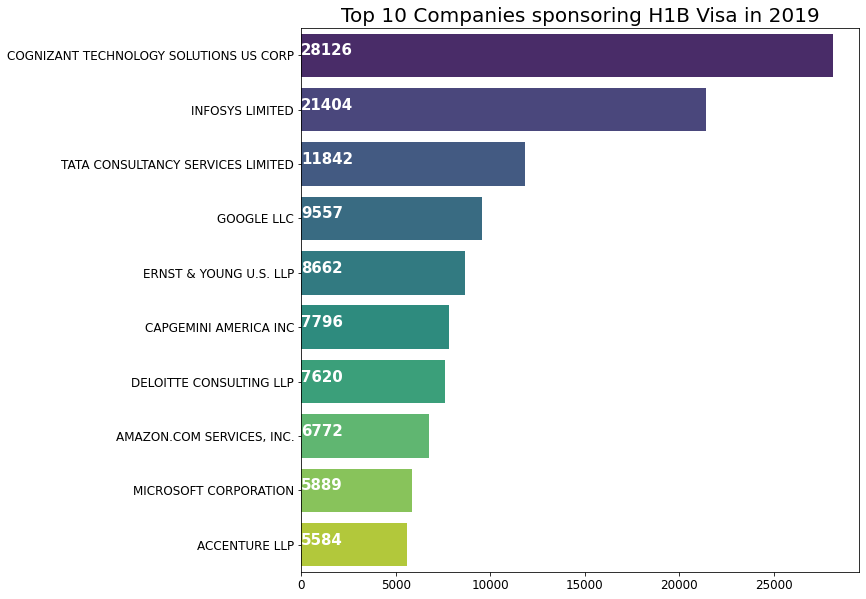

In [0]:
plt.figure(figsize=[10,10])
ax=sns.barplot(y=Top_Employer.index,x=Top_Employer.values,palette=sns.color_palette('viridis',10))
ax.tick_params(labelsize=12)
for i, v in enumerate(Top_Employer.values): 
    ax.text(.5, i, v,fontsize=15,color='white',weight='bold')
plt.title('Top 10 Companies sponsoring H1B Visa in 2019', fontsize=20)
plt.show()

In [0]:
grouped_wages=cleaned.groupby('JOB_TITLE', as_index=False).agg({'WAGES':'mean'})
op=grouped_wages.sort_values(by=['WAGES'],ascending=False)
#X=op.loc[op['JOB_TITLE']=='software engineer']
display(op)
display(X)

,JOB_TITLE,WAGES
86317,SOFTWARE ENGINEER 1615.36850,357136000.0
83619,SOFTWARE ENGINEER (1615.46146),110293000.0
69997,SENIOR APPLICATIONS ENGINEER - POWER MANAGEMENT,98847500.0
50799,NURSE PRACTITIONERS (LICENSED),97780945.6
91802,SPECIALIST WEB DEVELOPER,74060709.0
...,...,...
49902,NAIL TECHNICAN,18720.0
19344,"CUSTOMER SERVICE, ALL TASKS & DUTIES OF A NAIL...",18200.0
104199,TRACK AND FIELD COACH,17040.0
43538,LIVE STREAMING SERVICE,17000.0


,JOB_TITLE,WAGES
83055,SOFTWARE ENGINEER,112102.821495
